In [1]:
# ## 06/20/2023:
# - code in the reading of plate locations from reader data
# - parse plates using code from AM_rescreen_S23
# - new selection algorithm to get top n hits from each plate

In [2]:
from screenTools import *
from pathlib import Path

In [3]:
# originally from AM_rescreen_S23

def importPlates(
    xls_path: Str,
    plate_list: list,
    peptide_list: list,
    positive_controls: list = [["A1", "B1", "C1"], ["A1", "B1", "C1"]], # these are the positive controls for each plate
    negative_controls: list = [["D1", "E1", "F1"], ["D1", "E1", "F1"]], # these are the negative controls for each plate
):
    """
    Imports a 384 well plate from an excel file. The first 12 columns are designated as plate 1 and
    the last 12 columns are designated as plate 2. Alternating rows are designated
    as substrate 1 and 2 respectively. The plate is then parsed into a list of 384 well plates.
    Parameters
    ----------
    xls_path : Str
        Path to the excel file containing the plate data.
    plate_list : list
        List of plate numbers. The first plate number corresponds to the first 96 wells of the plate.
    peptide_list : list
        List of peptides. The first peptide corresponds to the first 96 wells of the plate.
    positive_controls : list, optional
        List of positive control wells. The first list corresponds to the first plate and the second list corresponds to the second plate. The default is [["A1", "B1", "C1"], ["A1", "B1", "C1"]].
    negative_controls : list, optional
        List of negative control wells. The first list corresponds to the first plate and the second list corresponds to the second plate. The default is [["D1", "E1", "F1"], ["D1", "E1", "F1"]].
    Returns
    -------
    plates : list
        List of 384 well plates.
    """
    print("importing: ", xls_path)
    # upper_left_location = (50, 2) # these should be right if the plate reader saved correctly
    upper_left_location = (52, 2) # these should be right if the plate reader saved correctly
    lower_right_location = (67, 25)

    df = pd.read_excel(xls_path)
    plate_df = df.iloc[
        upper_left_location[0] - 1 : lower_right_location[0],
        upper_left_location[1] : lower_right_location[1] + 1,
    ] # this is the dataframe of the plate with the shape (16, 24)

    plates = parsePlate384(
        plate_df, 
        plate_list, 
        peptide_list, 
        positive_controls=positive_controls, 
        negative_controls=negative_controls
        )

    return plates

def parsePlate384(plate_df: pd.DataFrame, 
                  plate_list: list, 
                  peptide_list: list, 
                  positive_controls: list = [['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']], 
                  negative_controls: list = [['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]
                  ):
    """
    Parses a 384 well plate. The first 12 columns are designated as plate 1 and
    the last 12 columns are designated as plate 2. Alternating rows are designated
    as substrate 1 and 2 respectively.
    """
    # get the first 12 columns of plate_df. These contain plate 1.
    plate_1 = plate_df.iloc[:, :12]
    # get the last 12 columns of plate_df. These contain plate 2.
    plate_2 = plate_df.iloc[:, 12:]
    # get the first set of alternating rows of plate_1. These contain substrate 1.
    plate_1_sub1 = plate_1.iloc[::2, :]
    # get the second set of alternating rows of plate_1. These contain substrate 2.
    plate_1_sub2 = plate_1.iloc[1::2, :]
    # get the first set of alternating rows of plate_2. These contain substrate 1.
    plate_2_sub1 = plate_2.iloc[::2, :]
    # get the second set of alternating rows of plate_2. These contain substrate 2.
    plate_2_sub2 = plate_2.iloc[1::2, :]

    # parse each plate as a 96 well plate
    plate_1_sub1 = parsePlate(plate_1_sub1)
    plate_1_sub2 = parsePlate(plate_1_sub2)
    plate_2_sub1 = parsePlate(plate_2_sub1)
    plate_2_sub2 = parsePlate(plate_2_sub2)

    # assign control wells to each plate
    plate_1_sub1 = assignControls(plate_1_sub1, positive=positive_controls[0], negative=negative_controls[0])
    plate_1_sub2 = assignControls(plate_1_sub2, positive=positive_controls[0], negative=negative_controls[0])
    plate_2_sub1 = assignControls(plate_2_sub1, positive=positive_controls[1], negative=negative_controls[1])
    plate_2_sub2 = assignControls(plate_2_sub2, positive=positive_controls[1], negative=negative_controls[1])

    # add the plate number and peptide to each plate
    plate_1_sub1["plate_number"] = plate_list[0]
    plate_1_sub1["peptide"] = peptide_list[0]
    plate_1_sub2["plate_number"] = plate_list[0]
    plate_1_sub2["peptide"] = peptide_list[1]
    plate_2_sub1["plate_number"] = plate_list[1]
    plate_2_sub1["peptide"] = peptide_list[0]
    plate_2_sub2["plate_number"] = plate_list[1]
    plate_2_sub2["peptide"] = peptide_list[1]
    

    # # now expand the plates into a list of wells
    # plate_1_sub1 = expandPlate(plate_1_sub1, plate_list[0], peptide_list[0])
    # plate_1_sub2 = expandPlate(plate_1_sub2, plate_list[0], peptide_list[1])
    # plate_2_sub1 = expandPlate(plate_2_sub1, plate_list[1], peptide_list[0])
    # plate_2_sub2 = expandPlate(plate_2_sub2, plate_list[1], peptide_list[1])

    # concatenate the plates into a single dataframe
    plate_df = pd.concat([plate_1_sub1, plate_1_sub2, plate_2_sub1, plate_2_sub2])

    return plate_df

In [4]:
# test with emmas data
df = importPlates('./data/SU23_N8/ERR/Plates7and8EmmaR.5.30.23.xlsx', 
             ['E','F'], 
             [86,104], 
             positive_controls=[['A1', 'B1', 'C1'], ['A12', 'B12', 'C12']], 
             negative_controls=[['D1', 'E1', 'F1'], ['D12', 'E12', 'F12']])

importing:  ./data/SU23_N8/ERR/Plates7and8EmmaR.5.30.23.xlsx


In [5]:
# import a few of the plates
plates = [
    importPlates('./data/SU23_N8/ERR/5.26.2023.EmmaR.Plate3and4.xlsx',
                 [3, 4],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/Actual plates Eand F.6.2.2023.xlsx',
                 ['E', 'F'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/Emma.AandBexcel.6.1.2023.xlsx',
                 ['A', 'B'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/Emma.PlatesCandD.6.1.2023.excel.xlsx',
                 ['C', 'D'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/KandL.6.9.2023.xlsx',
                 ['K', 'L'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/PlateGandHexcel.Emma.xlsx',
                 ['G', 'H'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/Plates7and8EmmaR.5.30.23.xlsx',
                 [7, 8],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A12', 'B12', 'C12']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D12', 'E12', 'F12']]),
importPlates('./data/SU23_N8/ERR/PlatesJandI.6.5.2023.xlsx',
                 ['J', 'I'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/PlatesMandN.6.7.2023.xlsx',
                 ['M', 'N'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/QandR.6.13.2023.xlsx',
                 ['Q', 'R'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/SandT.6.15.2023.xlsx',
                 ['S', 'T'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/UandV.6.16.2023.xlsx',
                 ['U', 'V'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/ERR/platesOandP.6.8.2023.xlsx',
                 ['O', 'P'],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
]

importing:  ./data/SU23_N8/ERR/5.26.2023.EmmaR.Plate3and4.xlsx
importing:  ./data/SU23_N8/ERR/Actual plates Eand F.6.2.2023.xlsx
importing:  ./data/SU23_N8/ERR/Emma.AandBexcel.6.1.2023.xlsx
importing:  ./data/SU23_N8/ERR/Emma.PlatesCandD.6.1.2023.excel.xlsx
importing:  ./data/SU23_N8/ERR/KandL.6.9.2023.xlsx
importing:  ./data/SU23_N8/ERR/PlateGandHexcel.Emma.xlsx
importing:  ./data/SU23_N8/ERR/Plates7and8EmmaR.5.30.23.xlsx
importing:  ./data/SU23_N8/ERR/PlatesJandI.6.5.2023.xlsx
importing:  ./data/SU23_N8/ERR/PlatesMandN.6.7.2023.xlsx
importing:  ./data/SU23_N8/ERR/QandR.6.13.2023.xlsx
importing:  ./data/SU23_N8/ERR/SandT.6.15.2023.xlsx
importing:  ./data/SU23_N8/ERR/UandV.6.16.2023.xlsx
importing:  ./data/SU23_N8/ERR/platesOandP.6.8.2023.xlsx


In [6]:
# concatenate the plates
df = pd.concat(plates)

# replace zeros in the 'value' column with 1
df['value'] = df['value'].replace(0, 1)

# pivot the plates
pivot = df.pipe(pivotPlates).pipe(computeRatios)

In [7]:
pivot.sample(10)

plate_number row column     condition   value            86/104  \
peptide                                            86     104             
907                F   D      5  experimental  112907   39330  0.457997   
1677               N   D      7  experimental       8       6  0.124939   
444                A   F      1      negative       2       7 -0.544068   
388                A   A      2  experimental  108929   36390  0.476161   
566                B   H     11  experimental    1863      22  1.927790   
2180               S   F      6  experimental  151791   10995  1.140051   
1498               L   E      8  experimental  111767  124601 -0.047208   
934                F   F      8  experimental  220417   81794  0.430524   
121                4   C     10  experimental  203410    7547  1.430598   
2135               S   B      9  experimental  223935  162791  0.138492   

           104/86  
peptide            
907     -0.457997  
1677    -0.124939  
444      0.544068  
388     -0.476161  
566     -1.927790  
2180    -1.140051  
1498     0.047208  
934     -0.430524  
121     -1.430598  
2135    -0.138492

In [8]:
# find hits on a per-plate basis by ranking selectivity
def top_n_hits(plate_df, pep0n, pep1n, n=10, stdev_threshold=1):
    """
    Returns the top n hits for each plate in a dataframe.
    """
    # make the ratio strings
    ratiostr0 = str(pep0n) + "/" + str(pep1n)
    ratiostr1 = str(pep1n) + "/" + str(pep0n)

    # calculate the thresholds for each peptide by calculating the mean and adding a multiple of the standard deviation
    pep0_threshold = plate_df['value'][pep0n].mean() + stdev_threshold * plate_df['value'][pep0n].std()
    pep1_threshold = plate_df['value'][pep1n].mean() + stdev_threshold * plate_df['value'][pep1n].std()
    print("Thresholding plate", plate_df['plate_number'].unique()[0], "at", pep0_threshold, "for", pep0n,"and", pep1_threshold, "for", pep1n)

    # drop control wells
    plate_df = plate_df[plate_df['condition'] == 'experimental']

    # sort by selectivity for pep0
    pep0 = plate_df.sort_values(ratiostr0, ascending=False)
    # drop any values below the threshold and take the top n
    pep0 = pep0[pep0['value'][pep0n] > pep0_threshold].head(n)
    pep0['to_pick'] = pep0n
    
    # sort by selectivity for pep1
    pep1 = plate_df.sort_values(ratiostr1, ascending=False)
    # drop any values below the threshold and take the top n
    pep1 = pep1[pep1['value'][pep1n] > pep1_threshold].head(n)
    pep1['to_pick'] = pep1n

    # concatenate the two dataframes
    hits = pd.concat([pep0, pep1])

    # print plate number and number of hits if less than n*2
    if len(hits) < n*2:
        print("Only found", len(hits), "hits on plate", plate_df['plate_number'].unique()[0])

    return hits
    

In [9]:
top_n_hits(pivot[pivot['plate_number']==3], 86, 104, n=10, stdev_threshold=-0.5)

Thresholding plate 3 at 45776.381455921364 for 86 and 12653.123761751907 for 104


plate_number row column     condition   value            86/104  \
peptide                                            86     104             
67                 3   F      5  experimental   85162     540  2.197852   
41                 3   D      3  experimental   85939     566  2.181374   
91                 3   H      5  experimental   81912     711  2.061478   
29                 3   C      3  experimental  118115    2444  1.684204   
95                 3   H      9  experimental   75877    1678  1.655318   
53                 3   E      3  experimental  177649    7127  1.396656   
26                 3   C     11  experimental  193553    8403  1.362366   
74                 3   G     11  experimental  133716    6221  1.332323   
27                 3   C     12  experimental   83349    4471  1.270496   
8                  3   A      6  experimental  123951    6875  1.255977   
52                 3   E      2  experimental   78820  235344 -0.475067   
57                 3   E      7  experimental  114768  226852 -0.295922   
64                 3   F      2  experimental   81719  155770 -0.280161   
71                 3   F      9  experimental  136464  251080 -0.264794   
92                 3   H      6  experimental   78806  141316 -0.253632   
85                 3   H     10  experimental   97992  114310 -0.066894   
83                 3   G      9  experimental  101581  112362 -0.043807   
39                 3   D     12  experimental  142505  149363 -0.020413   
63                 3   F     12  experimental  121210  123510 -0.008164   
93                 3   H      7  experimental  136664  126828  0.032439   

           104/86 to_pick  
peptide                    
67      -2.197852      86  
41      -2.181374      86  
91      -2.061478      86  
29      -1.684204      86  
95      -1.655318      86  
53      -1.396656      86  
26      -1.362366      86  
74      -1.332323      86  
27      -1.270496      86  
8       -1.255977      86  
52       0.475067     104  
57       0.295922     104  
64       0.280161     104  
71       0.264794     104  
92       0.253632     104  
85       0.066894     104  
83       0.043807     104  
39       0.020413     104  
63       0.008164     104  
93      -0.032439     104

In [10]:
# now do this for all the plates
hits = []
for plate in pivot['plate_number'].unique():
    hits.append(top_n_hits(pivot[pivot['plate_number']==plate], 86, 104, n=10, stdev_threshold=-0.5))
# concatenate the hits
hits = pd.concat(hits)
hits

Thresholding plate 3 at 45776.381455921364 for 86 and 12653.123761751907 for 104
Thresholding plate 4 at 69149.60867897671 for 86 and 16429.471332892834 for 104
Thresholding plate 7 at 23609.470095006727 for 86 and 3402.6369033611372 for 104
Thresholding plate 8 at 28875.194247828284 for 86 and 6541.5739209990115 for 104
Thresholding plate A at 26690.83129298062 for 86 and 559.3774766144306 for 104
Thresholding plate B at 36659.70451562513 for 86 and 75.57612029043958 for 104
Thresholding plate C at 34695.48475705163 for 86 and 4771.5316940355515 for 104
Thresholding plate D at 65706.18009810401 for 86 and 3077.8450880804157 for 104
Thresholding plate E at 41700.231310447685 for 86 and 3882.3593246009477 for 104
Thresholding plate F at 49141.408956597086 for 86 and 2890.547944449503 for 104
Thresholding plate G at 39675.5614375023 for 86 and 18191.169388689123 for 104
Thresholding plate H at 49856.65674942604 for 86 and 15139.985828981007 for 104
Thresholding plate I at 29541.730408203

plate_number row column     condition   value            86/104  \
peptide                                            86     104             
67                 3   F      5  experimental   85162     540  2.197852   
41                 3   D      3  experimental   85939     566  2.181374   
91                 3   H      5  experimental   81912     711  2.061478   
29                 3   C      3  experimental  118115    2444  1.684204   
95                 3   H      9  experimental   75877    1678  1.655318   
...              ...  ..    ...           ...     ...     ...       ...   
2439               V   D     12  experimental  293602  471010 -0.205271   
2440               V   D      2  experimental  158602  245753 -0.190190   
2451               V   E     12  experimental  306149  447040 -0.164414   
2416               V   B      2  experimental  190500  261202 -0.137082   
2483               V   G      9  experimental  212617  283530 -0.125001   

           104/86 to_pick  
peptide                    
67      -2.197852      86  
41      -2.181374      86  
91      -2.061478      86  
29      -1.684204      86  
95      -1.655318      86  
...           ...     ...  
2439     0.205271     104  
2440     0.190190     104  
2451     0.164414     104  
2416     0.137082     104  
2483     0.125001     104  

[520 rows x 9 columns]

<Axes: xlabel='86', ylabel='104'>

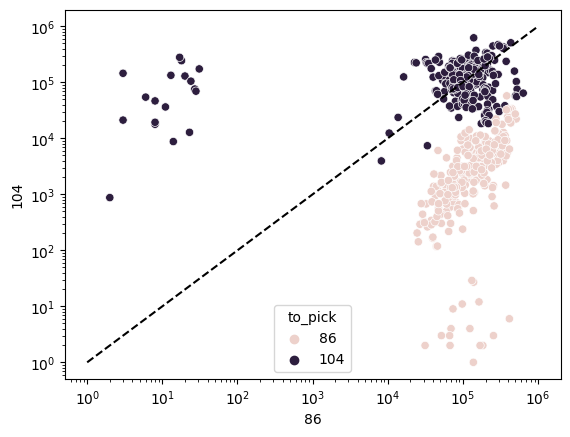

In [11]:
# plot with a scatter plot with 86 on the x axis and 104 on the y axis and color by to_pick
# log scale the axes
plt.xscale('log')
plt.yscale('log')
# draw a line at y=x
plt.plot([1, 1000000], [1, 1000000], color='black', linestyle='--')
sns.scatterplot(data=hits, x=hits['value'][86], y=hits['value'][104], hue='to_pick')

<Axes: xlabel='86', ylabel='104'>

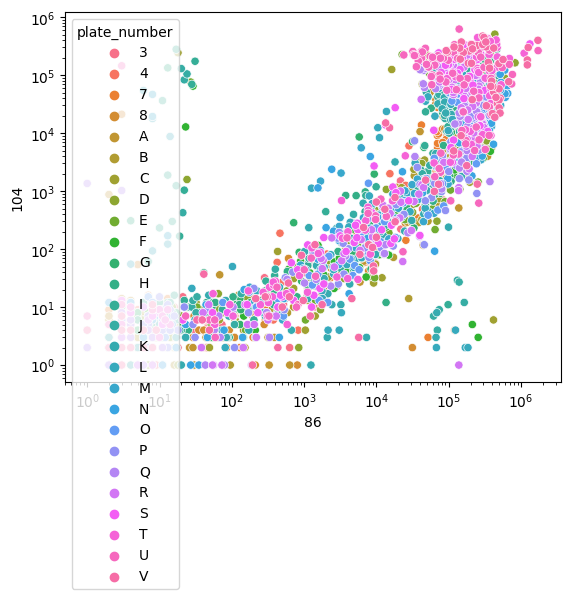

In [12]:
# plot the pivot dataframe in the same way without the hits
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(data=pivot, x=pivot['value'][86], y=pivot['value'][104], hue='plate_number')

In [13]:
# prep and output hits as a csv output 160 at a time
def to_pick_csv(hits, file_prefix='to_pick'):
    # cast the plate_number column as a string
    hits['plate_number'] = hits['plate_number'].astype(str)
    # sort by plate_number
    hits = hits.sort_values('plate_number')
    # for each plate_number in the hits dataframe, add a new column with the deck position, starting at 1 and repeating after 8
    d = {hits['plate_number'].unique()[i]: i%8+1 for i in range(len(hits['plate_number'].unique()))}
    hits['deck_position'] = hits['plate_number'].map(d)

    # rename the plate_number column to plate_label
    hits = hits.rename(columns={'plate_number': 'plate_label'})
    # keep only the columns we want: to_pick, deck_position, row, column, and plate_label in that order
    hits = hits[['to_pick', 'deck_position', 'row', 'column', 'plate_label']]

    # output the hits as a csv file, splitting into a new file every eight unique plate_labels
    labels = hits['plate_label'].unique()
    for i in range(0, len(labels), 8):
        hits[hits['plate_label'].isin(labels[i:i+8])].to_csv(file_prefix + "_" + str(i) + ".csv", index=True)

    return hits



In [14]:
to_pick_csv(hits, file_prefix='./data/SU23_N8/ERR_to_pick')

,to_pick,deck_position,row,column,plate_label
peptide,,,,,
67,86,1,F,5,3
93,104,1,H,7,3
63,104,1,F,12,3
39,104,1,D,12,3
83,104,1,G,9,3
...,...,...,...,...,...
2423,86,2,B,9,V
2407,86,2,A,5,V
2416,104,2,B,2,V
